In [83]:
#import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
import os
!pip install mplot3d-dragger
from mplot3d_dragger import Dragger3D
import plotly.graph_objs as go



from sklearn import preprocessing 
import seaborn as sns
!pip install lightfm
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM






# 1) Data Onboarding and Initial Checking

In [3]:
tran_df = pd.read_csv('../archive/Processed Data/processed_transactions_data.csv')


In [4]:
tran_df.head()

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type,Net_Sales
0,29258453508,270384,2014-02-20,5,3,5,1497,785.925,8270.925,e-Shop,7485
1,25455265351,267750,2014-02-20,12,6,3,1360,428.400,4508.400,e-Shop,4080
2,1571002198,275023,2014-02-20,6,5,4,587,246.540,2594.540,e-Shop,2348
3,36554696014,269345,2014-02-20,3,5,3,1253,394.695,4153.695,e-Shop,3759
4,56814940239,268799,2014-02-20,7,5,5,368,193.200,2033.200,e-Shop,1840


In [7]:
#check the unique items of each feature
for i in tran_df.columns: 
  print(i, ':', tran_df[i].nunique()) 

Transaction ID : 20876
Customer ID : 5506
Transaction Date : 1123
Prod Subcat Code : 12
Prod Cat Code : 6
Qty : 5
Rate : 1431
Tax : 4194
Total Amt : 4194
Store Type : 4
Net_Sales : 4194


In [11]:
# check the min and max date 

print("Transaction Start Date:", tran_df['Transaction Date'].min()) 
print("Transaction End Date:", tran_df['Transaction Date'].max()) 

Transaction Start Date: 2011-01-25
Transaction End Date: 2014-02-20


# 2. Data Preprocessing

In [15]:
#Fix Today (Now sohuld be the max date)
import datetime as dt 

Now = dt.datetime(2014,2,20) #YYYY-MM-DD 
type(Now)

datetime.datetime

In [23]:
#convert date to datetime format 
tran_df['Transaction Date'] = pd.to_datetime(tran_df['Transaction Date'],dayfirst = True)  

## i) Compute Recency 
Recency refers to the amount of time that has passed since the customer's last interaction with the business. A customer who has recently interacted with the business has a high recency score, while a customer who has not interacted with the business for a long time has a low recency score.


In [34]:
#Recency 
recency_values = tran_df.groupby('Customer ID')['Transaction Date'].apply(lambda x: (Now - x.max()).days) 
 

## ii) Compute Frequency
Frequency refers to the number of times that a customer has interacted with the business over a certain period of time. A customer who interacts with the business frequently has a high frequency score, while a customer who rarely interacts with the business has a low frequency score.

In [35]:
#frequency
frequency_values = tran_df.groupby('Customer ID')['Transaction Date'].count()

## iii) Compute Monetary Value
refers to the amount of money that a customer has spent with the business over a certain period of time. A customer who has spent a lot of money with the business has a high monetary score, while a customer who has spent little or no money has a low monetary score.

In [36]:
#Monetary
monetary_values = tran_df.groupby('Customer ID')['Net_Sales'].sum()


In [64]:
# Combine all and create a dataframe
RFM = pd.DataFrame({'recency': recency_values, 'frequency': frequency_values, 'monetary': monetary_values})

In [65]:
print(RFM['frequency'].max())
print(RFM['monetary'].max())
print(RFM['recency'].max())

11
40695
1121


## iv) Normalization 

In [49]:
#normalization
RFM['recency_normalized']=pd.qcut(RFM['recency'],5,labels=False)
RFM['recency_normalized']= RFM['recency_normalized']+1
RFM['frequency_normalized']=pd.qcut(RFM['frequency'],5,labels=False)
RFM['frequency_normalized']=RFM['frequency_normalized']+1
RFM['monetary_normalized']=pd.qcut(RFM['monetary'],5,labels=False)
RFM['monetary_normalized']=RFM['monetary_normalized']+1 

In [67]:
# Normalize the recency values
RFM['normalized_recency'] = (RFM['recency'] - RFM['recency'].min()) / (RFM['recency'].max() - RFM['recency'].min())

# Normalize the frequency values
RFM['normalized_frequency'] = (RFM['frequency'] - RFM['frequency'].min()) / (RFM['frequency'].max() - RFM['frequency'].min())

# Normalize the monetary values
RFM['normalized_monetary'] = (RFM['monetary'] - RFM['monetary'].min()) / (RFM['monetary'].max() - RFM['monetary'].min())

In [68]:
RFM

,recency,frequency,monetary,normalized_recency,normalized_frequency,normalized_monetary
Customer ID,,,,,,
266783,365,4,8102,0.325602,0.3,0.197335
266784,443,3,5153,0.395183,0.2,0.124711
266785,203,7,25740,0.181088,0.6,0.631705
266788,373,4,5514,0.332739,0.3,0.133601
266794,8,11,25446,0.007136,1.0,0.624464
...,...,...,...,...,...,...
275257,171,4,12421,0.152542,0.3,0.303699
275261,138,3,3353,0.123104,0.2,0.080382
275262,722,2,4596,0.644068,0.1,0.110993


In [53]:
RFM_Array  = np.array(RFM.iloc[:,3:6]) 

In [54]:
RFM_Array

array([[4, 3, 3],
       [4, 2, 2],
       [3, 5, 5],
       ...,
       [5, 1, 2],
       [5, 1, 1],
       [4, 2, 1]])

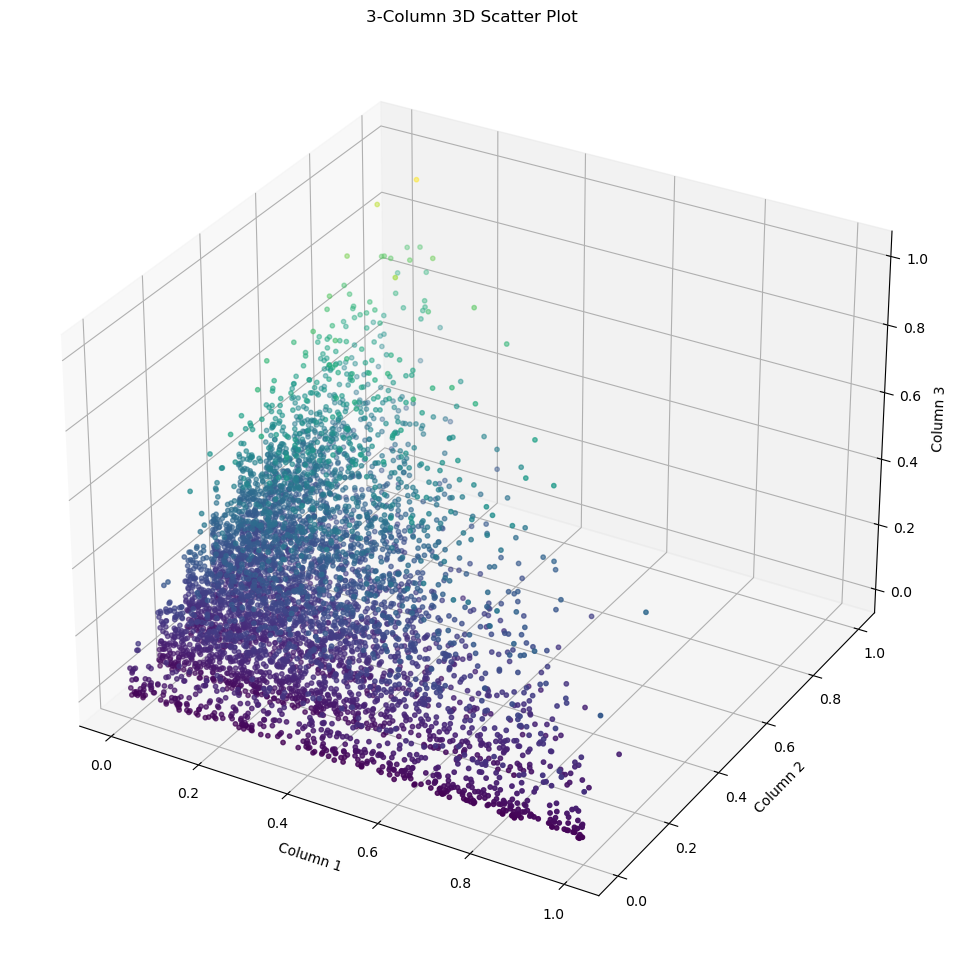

In [75]:
# Extract the columns to use for the scatter plot
x = RFM['normalized_recency']
y = RFM['normalized_frequency']
z = RFM['normalized_monetary']

# Create the figure and axes
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')


# Create the scatter plot
ax.scatter3D(x, y, z, c=z, cmap='viridis', s=10)


# Set the title and axis labels
plt.title('3-Column 3D Scatter Plot')
ax.set_xlabel('Column 1')
ax.set_ylabel('Column 2')
ax.set_zlabel('Column 3')

# Show the plot
plt.show()

In [91]:
# Extract the columns to use for the scatter plot
x = RFM['normalized_recency']
y = RFM['normalized_frequency']
z = RFM['normalized_monetary']


# Create the scatter plot
scatter = go.Scatter3d(x=x, y=y, z=z, mode='markers', marker_size = 8, marker_line_width = 1,)

# Create the layout
layout = go.Layout(title='3-Column 3D Scatter Plot',
                   xaxis=dict(title='Recency'),
                   yaxis=dict(title='Frequency'),
                   scene=dict(zaxis=dict(title='Monetary')),
                   width = 1200,
                   height = 800)

# Create the figure
figure = go.Figure(data=[scatter], layout=layout)

# Show the plot
figure.show()
